# Examen Primer Parcial 
### Laboratorio de Aprendizaje Estadístico

José Armando Melchor Soto

--- 




### Librerías: 

In [997]:
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
import numpy as np
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from sklearn import linear_model
import statsmodels.formula.api as smf
import warnings
from scipy import stats
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
from xgboost import XGBRegressor
import seaborn as sns
from lightgbm import plot_importance


warnings.simplefilter(action='ignore', category=FutureWarning)


### Dataset : 
Hitters

In [998]:
df = pd.read_csv('Hitters.csv')

----

### Visualización del Dataset

In [999]:
df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N


### Explicación de las variables 

A data frame with 322 observations of major league players on the following 20 variables.

AtBat Number of times at bat in 1986

Hits Number of hits in 1986

HmRun Number of home runs in 1986

Runs Number of runs in 1986

RBI Number of runs batted in in 1986

Walks Number of walks in 1986

Years Number of years in the major leagues

CAtBat Number of times at bat during his career

CHits Number of hits during his career

CHmRun Number of home runs during his career

CRuns Number of runs during his career

CRBI Number of runs batted in during his career

CWalks Number of walks during his career

League A factor with levels A and N indicating player’s league at the end of 1986

Division A factor with levels E and W indicating player’s division at the end of 1986

PutOuts Number of put outs in 1986

Assists Number of assists in 1986

Errors Number of errors in 1986

Salary 1987 annual salary on opening day in thousands of dollars

NewLeague A factor with levels A and N indicating player’s league at the beginning of 1987

---

### Se busca predecir el Salario de este Df

In [1000]:
df['Salary']

0         NaN
1       475.0
2       480.0
3       500.0
4        91.5
        ...  
317     700.0
318     875.0
319     385.0
320     960.0
321    1000.0
Name: Salary, Length: 322, dtype: float64

In [1001]:
target= 'Salary'

### Dummies

In [1002]:
df= pd.get_dummies(df, drop_first=True)

### NaN's

In [1003]:
df.isna().sum()


AtBat           0
Hits            0
HmRun           0
Runs            0
RBI             0
Walks           0
Years           0
CAtBat          0
CHits           0
CHmRun          0
CRuns           0
CRBI            0
CWalks          0
PutOuts         0
Assists         0
Errors          0
Salary         59
League_N        0
Division_W      0
NewLeague_N     0
dtype: int64

La variable a predecir es la única que tiene bastantes NaN , para esto tenemos que llenarlas o quitarlas. En este caso vamos a quitarlas. 

In [1004]:
df= df[df['Salary'].notnull()]

Comprobamos que se hayan quitado:

In [1005]:
df.isna().sum()

AtBat          0
Hits           0
HmRun          0
Runs           0
RBI            0
Walks          0
Years          0
CAtBat         0
CHits          0
CHmRun         0
CRuns          0
CRBI           0
CWalks         0
PutOuts        0
Assists        0
Errors         0
Salary         0
League_N       0
Division_W     0
NewLeague_N    0
dtype: int64

### Modelo

Se pide que el modelo tenga: 

test: 20%
random_state: 42

Nuestro objetivo es: 

In [1006]:
target= 'Salary'

### Función

##### Calibración

In [1007]:
def calibracion(predicciones, y, bins):
    df_calibracion = pd.DataFrame({
        'predicciones': predicciones,
        'y': y
    })
    
    df_calibracion['bins'] = pd.qcut(df_calibracion['predicciones'], q=bins, labels=False) + 1
    gropuped = df_calibracion.groupby('bins').mean()
    
    plt.plot(gropuped.predicciones, gropuped.y, label="Modelo", marker="o")
    plt.plot(gropuped.predicciones, gropuped.predicciones, label="Real", marker="o")
    plt.grid()
    plt.legend()
    plt.xlabel("Prediccion")
    plt.ylabel("Real")

##### Lightgbm

In [ ]:

def lightgbm(X_train, y_train, X_test, y_test):

    model_lightgbm = LGBMRegressor(
        num_iterations=10000,
        num_leaves=10,
        learning_rate=0.1,
        max_depth=6,
        lambda_l2=0.1,
        subsample=0.5,
        feature_fraction=0.8,
        verbosity=-1,
        metric='rmse'
    )

    model_lightgbm.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        eval_metric='rmse',
        callbacks=[
            early_stopping(stopping_rounds=20),
            log_evaluation(period=100)
        ]
    )

    predicciones_lightgbm = model_lightgbm.predict(X_test)
    print("R^2", r2_score(y_test, predicciones_lightgbm))
    calibracion(predicciones_lightgbm, y_test, 20)
    plot_importance(model_lightgbm, max_num_features=5, importance_type='split')
    plot_importance(model_lightgbm, max_num_features=5, importance_type='gain')



##### CatBoost

In [1009]:
def catboost( X_train, y_train,X_test,y_test):
    cat_cols = [col for col in X_train.columns if X_train[col].nunique() < 50]


    for col in cat_cols:
        X_train[col] = X_train[col].astype(str).fillna('missing')
        X_test[col] = X_test[col].astype(str).fillna('missing')

    model_catboost = CatBoostRegressor(
        iterations=10_000,           
        depth=5,                   
        learning_rate=0.1,
        subsample=0.5,              
        rsm=0.8,                   
        eval_metric='R2',
        verbose = 100,
        early_stopping_rounds=50    
    )

    model_catboost.fit(
        X_train, y_train,
        cat_features=cat_cols,
        eval_set=[(X_test, y_test)],
    )

    predicciones_catboost = model_catboost.predict(X_test)
    print('R^2:' ,r2_score(y_pred=predicciones_catboost, y_true=y_test))
    calibracion(predicciones_catboost, y_test, 20)


    df_importances = pd.DataFrame({
        'feature': model_catboost.feature_names_,
        'importance': model_catboost.feature_importances_
    }).sort_values(by='importance', ascending=False)
    return df_importances.head(5)


##### XGBoost

In [1010]:
from xgboost import plot_importance as xgb_plot_importance

def xgboost(X_train, y_train, X_test, y_test):
    columnas_a_verificar = ['HmRun', 'Years', 'Errors', 'League_N', 'Division_W', 'NewLeague_N']
    
    for col in columnas_a_verificar:
        if col in X_train.columns:
            if X_train[col].astype(str).str.isnumeric().all():
                X_train[col] = X_train[col].astype(float)
                X_test[col] = X_test[col].astype(float)
            else:
                X_train[col] = X_train[col].astype('category')
                X_test[col] = X_test[col].astype('category')


    model_xgboost = XGBRegressor(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        reg_lambda=0.1,
        subsample=0.5,
        colsample_by_tree=0.8,
        tree_method='hist',
        enable_categorical=True,
        early_stopping_rounds=100,
    )

    model_xgboost.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=100)

    predicciones_xgboost= model_xgboost.predict(X_test)
    print(f'R^2:',r2_score(y_test, predicciones_xgboost))
    calibracion(predicciones_xgboost, y_test, 20)

    xgb_plot_importance(model_xgboost, max_num_features=5, importance_type='weight')
    xgb_plot_importance(model_xgboost, max_num_features=5, importance_type='gain')



### Feature engenieering 

In [1011]:
# Desempeño Ofensivo
df['Hits_Per_AtBat'] = df['Hits'] / df['AtBat']  # Tasa de hits por turno al bate
df['HomeRuns_Per_Hit'] = df['HmRun'] / df['Hits']  # Proporción de jonrones por hit

# Desempeño a lo largo de la carrera
df['Career_RBI_Per_AtBat'] = df['CRBI'] / df['CAtBat']  # Carreras impulsadas por turno al bate
df['Career_Runs_Per_Hit'] = df['CRuns'] / df['CHits']  # Carreras anotadas por hit
df['Career_Hits_Per_Year'] = df['CHits'] / df['Years']  # Hits por año de carrera

# Transformaciones logarítmica y raíz cuadrada
df['Log_Career_Runs'] = np.log(df['CRuns'])  # Logaritmo de carreras anotadas en la carrera
df['Sqrt_Career_Hits'] = np.sqrt(df['CHits'])  # Raíz cuadrada de los hits en la carrera



In [1012]:
pd.DataFrame(df.isnull().sum()).T

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,...,League_N,Division_W,NewLeague_N,Hits_Per_AtBat,HomeRuns_Per_Hit,Career_RBI_Per_AtBat,Career_Runs_Per_Hit,Career_Hits_Per_Year,Log_Career_Runs,Sqrt_Career_Hits
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Nueva Regresión Lineal con Feature engenieering 

In [1013]:
X = df.copy()
X = X.drop(columns=[target])
y = df[target]

In [1014]:
X_train, X_test, y_train, y_test = train_test_split(X, df[target], test_size=0.2, random_state=42)

model = linear_model.LinearRegression().fit(X_train, y_train)
predicciones = model.predict(X_test)

mse = mean_squared_error(y_pred=predicciones, y_true=y_test)

print('Mean Squared Error:', mse)
print('R^2: ', r2_score(y_pred=predicciones, y_true=y_test))

Mean Squared Error: 56502.291099212045
R^2:  0.6876117515920094


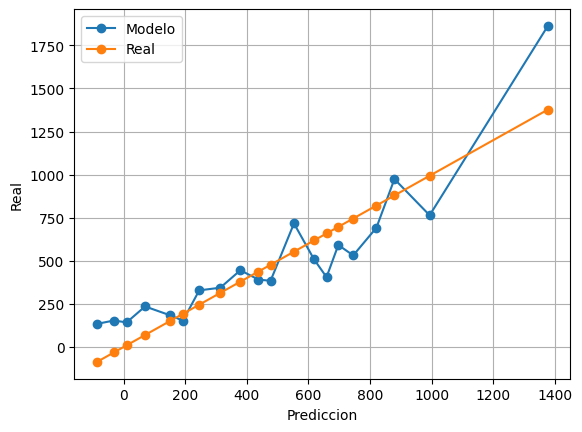

In [1015]:
calibracion(predicciones, y_test, 20)

Se obtuvo un $R^2$ bastante mayor del que estabamos viendo en modelos anteriores.

### Gradient Boosting

#### Lightgbm

Training until validation scores don't improve for 20 rounds
[100]	training's rmse: 106.632	valid_1's rmse: 328
Early stopping, best iteration is:
[156]	training's rmse: 72.5168	valid_1's rmse: 321.449
R^2 0.42871377118934617


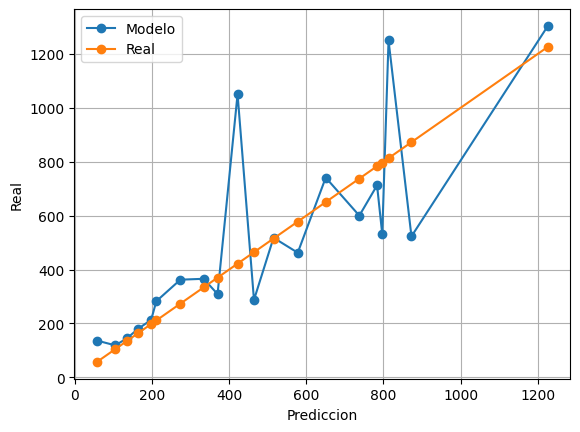

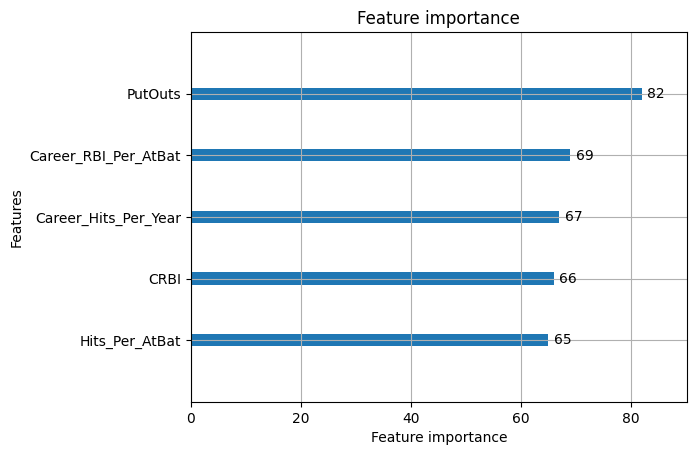

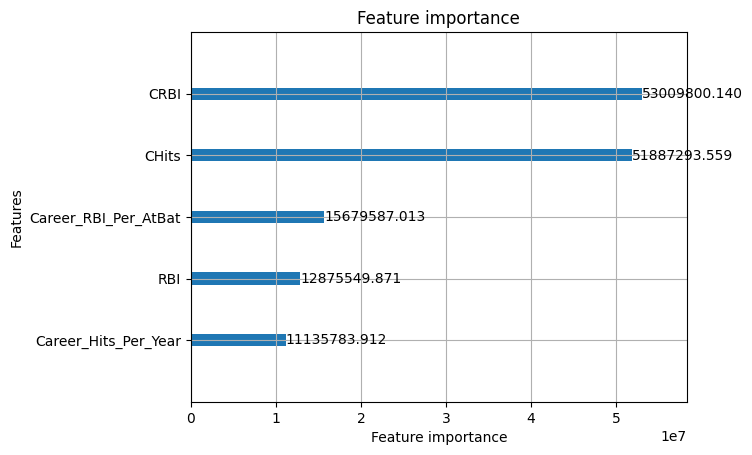

In [1016]:
lightgbm(X_train, y_train, X_test, y_test)

#### Catboost

0:	learn: 0.0823635	test: 0.0444172	best: 0.0444172 (0)	total: 24.1ms	remaining: 4m
100:	learn: 0.9515599	test: 0.5124665	best: 0.5124665 (100)	total: 2.83s	remaining: 4m 37s
200:	learn: 0.9878319	test: 0.5272860	best: 0.5287558 (195)	total: 5.7s	remaining: 4m 38s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5287558343
bestIteration = 195

Shrink model to first 196 iterations.
R^2: 0.5287558383281932


,feature,importance
8,CHits,12.621667
21,Career_RBI_Per_AtBat,10.705862
24,Log_Career_Runs,8.679195
5,Walks,6.703404
4,RBI,5.750291


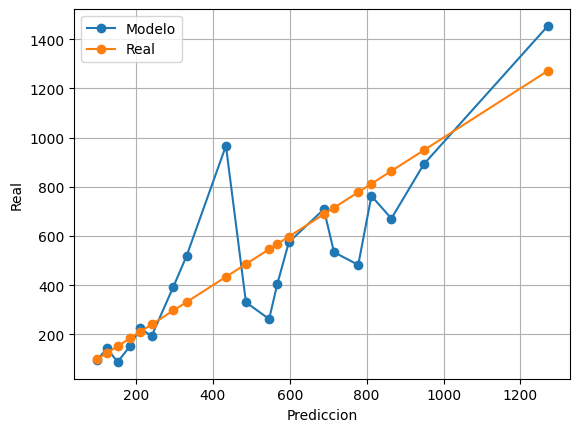

In [1017]:
catboost(X_train, y_train, X_test, y_test)

#### Xgboost

[0]	validation_0-rmse:407.89133
[99]	validation_0-rmse:283.25242


c:\Users\ppmel\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\callback.py:386: UserWarning: [20:23:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "colsample_by_tree" } are not used.

  self.starting_round = model.num_boosted_rounds()


R^2: 0.5731903198211654


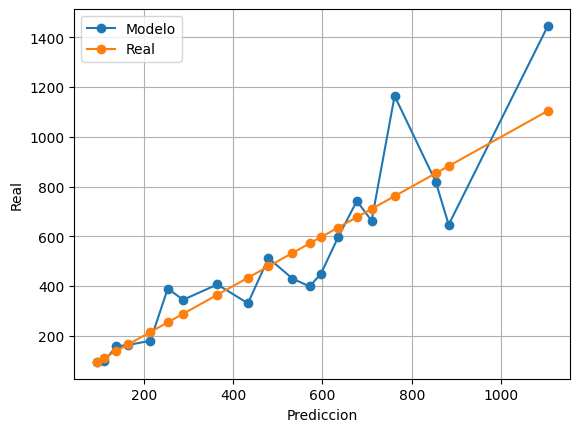

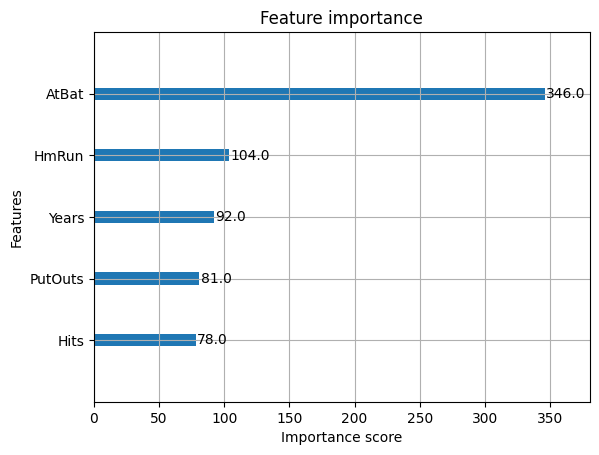

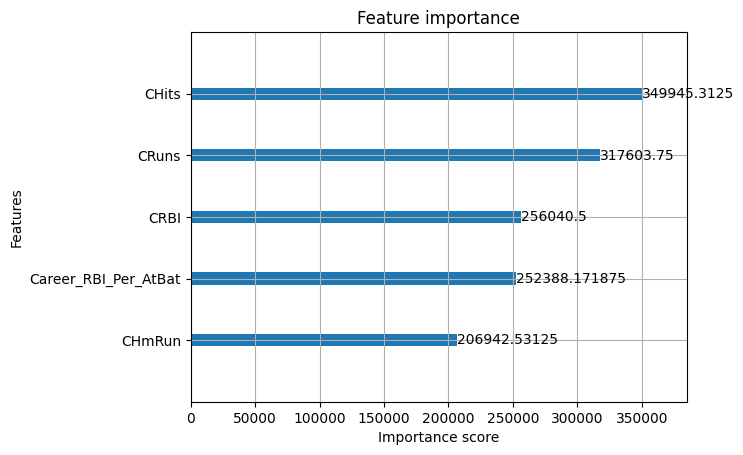

In [1018]:
xgboost(X_train, y_train, X_test, y_test)

## Conclusión Tarea Redes Neuronales

Se pudo observar que al hacer la red neuronal con los datos del examen , no se ve ninguna mejora a comparación del último gran $R^2$ que nos dio en el examen con feature engineering. Por otro lado , al hacer la nueva regresión lineal despues de haber hecho las redes neuronales, se pudo observar que casi que alcanza al valor , nomas por unos decimales está más bajo. Parece que el $R^2$ que nos dio , no es adecuado para predecir los salarios de los jugadores y seguimos con  el de feature engineering.

Se utilizaron diferentes parametros para ver si mejoraba y el que puse de (100,100),(100,100,100),(100,100,100),(100,100,100,100),(100,100,100,100,100) fue el que mejor $R^2$ dio, pero puede ser que haya aumentado mucho porque pudo haber overfitting en el modelo. 

# Conclusión Tarea Random Forest

Se puede observar que al aplicar Random Forest, no hubo mejoras en el $R^2$ de 0.6876. Sin embargo, al ajustar la profundidad máxima del modelo de 1 a 50 y utilizar 100 estimadores, se obtuvo un $ R^2$ de 0.5398. Esto indica que el modelo explica el 53.98% de la variabilidad de los datos. Aunque no logró superar el $R^2$ obtenido con feature engineering, sigue reflejando una capacidad aceptable para capturar la variabilidad presente en los datos. Se podrían requerir ajustes adicionales para mejorar su desempeño. Este modelo de Random Forest , tampoco mejoró al modelo de Redes Neuronales. 

# Conclusión Tarea Gradient Boosting

Se observó que, entre los tres modelos evaluados, Xgboost fue el que obtuvo el mejor desempeño en términos de $R^2$. A pesar de los ajustes realizados, el modelo alcanzó un $R^2$ de **0.5731**, lo que indica que logró explicar aproximadamente el **57.31%** de la variabilidad de los datos. Sin embargo, este resultado no superó el mejor desempeño alcanzado en tareas anteriores, donde con Feature Engineering se logró un $R^2$ de **0.6876**. Esto sugiere que, si bien Xgboost mostró solidez frente a los otros modelos en esta tarea, aún hay espacio para mejorar la capacidad predictiva del modelo.

## Conclusión Examen

El coeficiente de determinación $R^2 $ mejoró significativamente en comparación con los modelos anteriores, alcanzando un máximo de **0.6876** en la regresión Lineal. Esto indica que el modelo explica un **68.76%** de la variabilidad de los datos, reflejando una mejora considerable en el ajuste.  

Para evitar **overfitting**, se aplicó **validación cruzada (cross-validation)**, asegurando que el modelo no estuviera sobreajustado a los datos de entrenamiento y mantuviera una buena capacidad de generalización.  

Por último, con la creación de nuevas **variables (Feature Engineering)**, el modelo para predecir los salarios mostró una mejora significativa. Este paso resultó ser el factor más determinante en el rendimiento de los modelos predictivos, se aplicaron varios OLS , pero al final se pudo notar que no fue tan bueno como el que habíamos sacado de Feature Engineering.  
